In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from models.CaptionModalityClassifier import CaptionModalityClassifier
from dataset.CaptionDataModule import CaptionDataModule
from utils.caption_utils import load_embedding_matrix
import numpy as np

In [2]:
MAX_NUMBER_WORDS = 20000       # number of words to consider from embeddings vocabulary
MAX_WORDS_PER_SENTENCE = 300   # sentence maximum length
WORD_DIMENSION = 300           # number of features per embedding
NUM_CLASSES = 4                # 4 microscopy classes

DATA_PATH = '/workspace/data/multimodality_classification.csv'
EMBEDDINGS = '/workspace/data/embeddings'
BASE_IMG_DIR = '/workspace/data/'
BATCH_SIZE = 32

In [3]:
dm = CaptionDataModule(BATCH_SIZE,
                       DATA_PATH,
                       MAX_NUMBER_WORDS,
                       MAX_WORDS_PER_SENTENCE,
                       BASE_IMG_DIR,
                       num_workers=72)

In [4]:
dm.prepare_data()
dm.setup()

In [5]:
dm.vocab_size

7221

In [6]:
embeddings_dict = load_embedding_matrix(EMBEDDINGS, WORD_DIMENSION)

Dimension: 300; found 400000 word vectors.


In [7]:
if dm.vocab_size < MAX_NUMBER_WORDS:
    MAX_NUMBER_WORDS = dm.vocab_size + 1
embedding_matrix = np.zeros((MAX_NUMBER_WORDS, WORD_DIMENSION))
    
for word, idx in dm.word_index.items():    
    if idx < MAX_NUMBER_WORDS:
        word_embedding = embeddings_dict.get(word)
        if word_embedding is not None:
            embedding_matrix[idx] = word_embedding
        else:
            embedding_matrix[idx] = np.random.randn(WORD_DIMENSION)

In [17]:
model = CaptionModalityClassifier(
                 max_input_length=MAX_WORDS_PER_SENTENCE,
                 vocab_size=MAX_NUMBER_WORDS,
                 embedding_dim=WORD_DIMENSION,
                 filters=100,
                 embeddings=embedding_matrix,
                 num_classes=NUM_CLASSES,
                 train_embeddings=True,
                 lr=1e-3)

In [16]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import torch

wandb_logger = WandbLogger(project='pytorchlightning')
wandb_logger.experiment.save()
print(wandb_logger.experiment.name)

from pathlib import Path
import os
output_run_path = Path('./outputs') / wandb_logger.experiment.name 
os.makedirs(output_run_path, exist_ok=False)

early_stop_callback = EarlyStopping(
    min_delta=0.0,
    patience=5,
    verbose=True,
    mode='min'
)

trainer = Trainer(gpus=1,
                  default_root_dir=str(output_run_path),
                  early_stop_callback=early_stop_callback,
                  logger=None)
trainer.fit(model, dm)
trainer.save_checkpoint(str(output_run_path / 'final.pt'))

# torch.save(model.state_dict(), output_run_path / 'checkpoint.pt')


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type            | Params
---------------------------------------------
0 | accuracy | Accuracy        | 0     
1 | CNNText  | CNNTextBackbone | 2 M   
2 | fc       | Linear          | 1 K   


light-butterfly-13


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: You have set 4 number of classes if different from predicted (3) and target (2) number of classes
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: You have set 4 number of classes if different from predicted (2) and target (2) number of classes
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: You have set 4 number of classes if different from predicted (3) and target (3) number of classes
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: 
                    When using EvalResult(early_stop_on=X) or TrainResult(early_stop_on=X) the
                    'monitor' key of EarlyStopping has no effect.
                    Remove EarlyStopping(monitor=

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: You have set 4 number of classes if different from predicted (2) and target (3) number of classes
  warnings.warn(*args, **kwargs)


Saving latest checkpoint..
Epoch 00007: early stopping triggered.


In [13]:
trainer.weights_save_path

'/workspace/nb'

In [17]:
trainer.save_checkpoint(str(output_run_path / 'checkpoint2.pt'))

In [18]:
for x, y in dm.train_dataloader():
    break

In [21]:
# https://pytorch-lightning.readthedocs.io/en/latest/lr_finder.html#lr-finder
trainer = Trainer()
lr_finder = trainer.lr_find(model, dm)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type            | Params
---------------------------------------------
0 | accuracy | Accuracy        | 0     
1 | CNNText  | CNNTextBackbone | 2 M   
2 | fc       | Linear          | 1 K   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: You have set 4 number of classes if different from predicted (2) and target (1) number of classes
  warnings.warn(*args, **kwargs)


Saving latest checkpoint..
LR finder stopped early due to diverging loss.


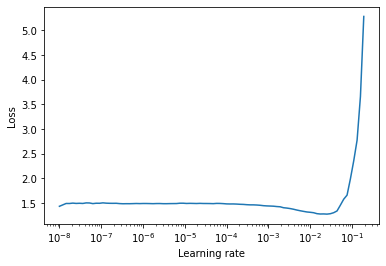

In [22]:
fig = lr_finder.plot(); fig.show()
suggested_lr = lr_finder.suggestion()

In [23]:
suggested_lr

0.00478630092322638